train Epoch [1/20] Loss: 2.6325 Acc: 0.1848
val Epoch [1/20] Loss: 2.2149 Acc: 0.3680
train Epoch [2/20] Loss: 2.2789 Acc: 0.2678
val Epoch [2/20] Loss: 2.0310 Acc: 0.4092
train Epoch [3/20] Loss: 2.1464 Acc: 0.2981
val Epoch [3/20] Loss: 2.0063 Acc: 0.4044
train Epoch [4/20] Loss: 2.0370 Acc: 0.3416
val Epoch [4/20] Loss: 1.8002 Acc: 0.4479
train Epoch [5/20] Loss: 1.9347 Acc: 0.3729
val Epoch [5/20] Loss: 1.8110 Acc: 0.4310
train Epoch [6/20] Loss: 1.8499 Acc: 0.3966
val Epoch [6/20] Loss: 1.7558 Acc: 0.4528
train Epoch [7/20] Loss: 1.7802 Acc: 0.4288
val Epoch [7/20] Loss: 1.6554 Acc: 0.4939
train Epoch [8/20] Loss: 1.4697 Acc: 0.5310
val Epoch [8/20] Loss: 1.4940 Acc: 0.5278
train Epoch [9/20] Loss: 1.3546 Acc: 0.5728
val Epoch [9/20] Loss: 1.4672 Acc: 0.5496
train Epoch [10/20] Loss: 1.2824 Acc: 0.5917
val Epoch [10/20] Loss: 1.4347 Acc: 0.5593
train Epoch [11/20] Loss: 1.1942 Acc: 0.6220
val Epoch [11/20] Loss: 1.3922 Acc: 0.6126
train Epoch [12/20] Loss: 1.1611 Acc: 0.6341
val E

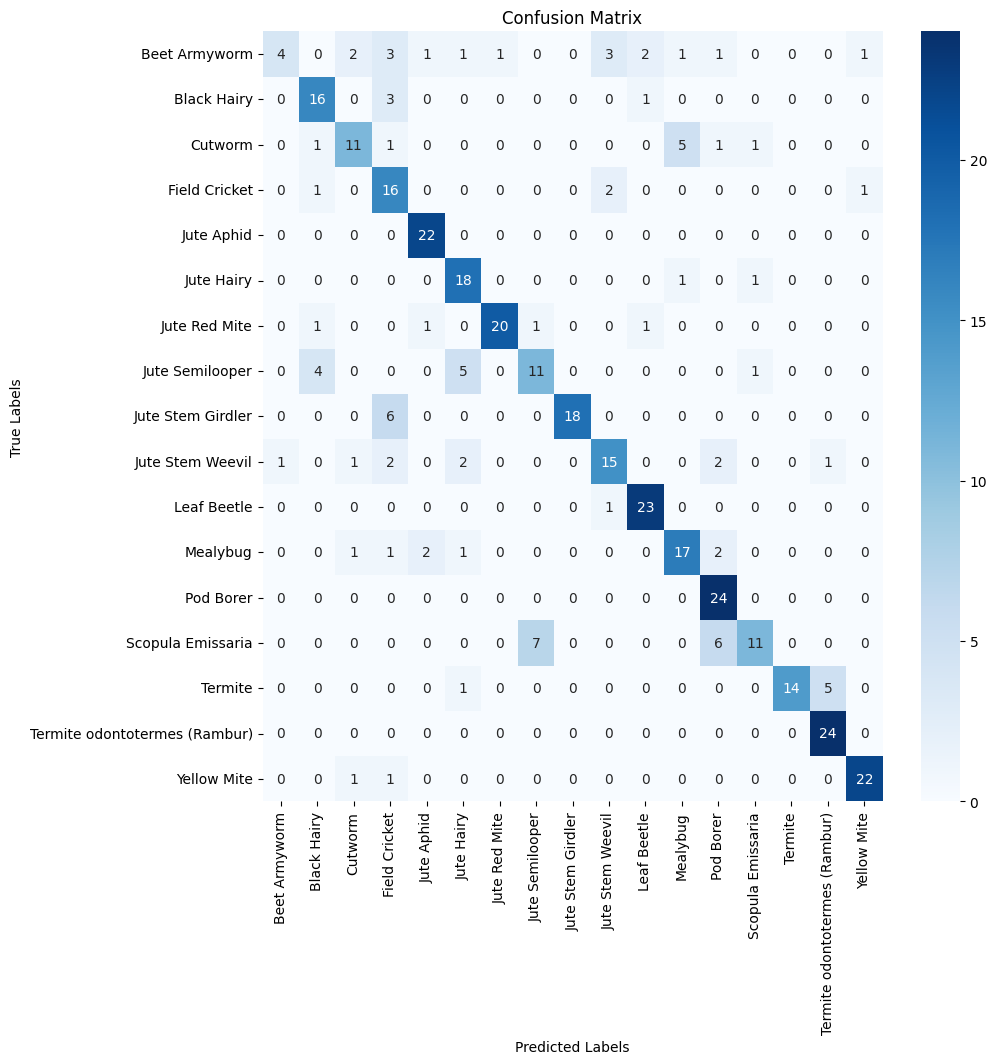

Precision: 0.7725, Recall: 0.7485, Test Accuracy: 0.7546


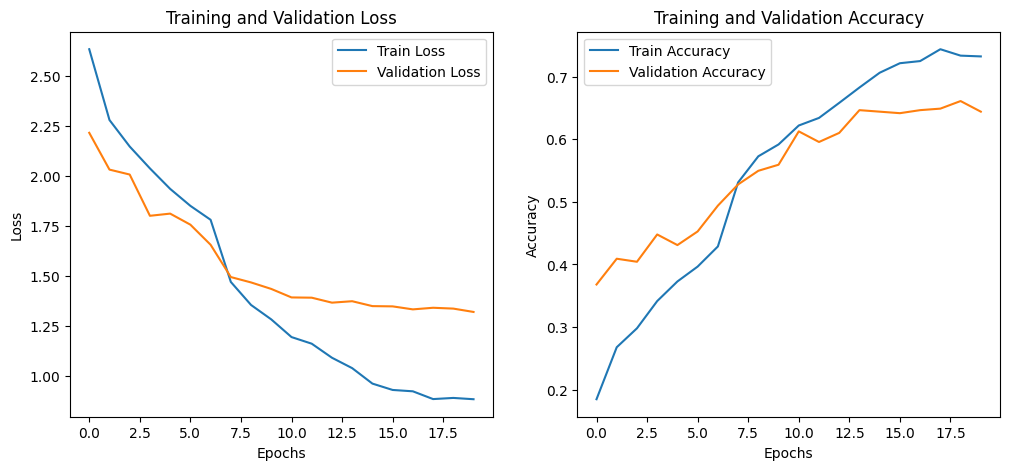

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define the neural network architecture
class MihiranNet(nn.Module):
    def __init__(self, num_classes=17):
        super(MihiranNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.fc = nn.Sequential(
            nn.Linear(36864, 4096),
            nn.LeakyReLU(negative_slope=0.01))
        self.fc1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(4096, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        x = self.fc1(x)
        return x

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/workspace/pattern/main/data/Jute_Pest_Dataset'
image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MihiranNet(num_classes=17).to(device)

# Optimizer, loss function, and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Arrays to track loss and accuracy for plotting
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item() 

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
            scheduler.step()
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc)

        print(f'{phase} Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Test phase
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dir = os.path.join(data_dir, 'test')
test_dataset = datasets.ImageFolder(test_dir, test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
confusion = confusion_matrix(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
test_acc = np.mean(np.array(all_preds) == np.array(all_labels))

# Displaying results
plt.figure(figsize=(10, 10))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, Test Accuracy: {test_acc:.4f}')

# Plotting training and validation losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), 'mihirannet.pth')


In [2]:
pip install scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 42.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 7.5 MB/s eta 0:00:0000:0100:01m

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 670.0 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 1.5 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 1.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 47.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 45.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
